In [1]:
import random 
import numpy as np 
import torch 


In [2]:
# The purpose of this file is to create a price tensor for input into the neural network
# and to train the policy using Deep Deterministic Policy Gradient.
# Code is inspired by the paper "A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem"
# For more details, see: c.f https://arxiv.org/abs/1706.10059


from typing import List
import torch 
from ddpgportfolio.agent.ddpg_agent import DDPGAgent
from ddpgportfolio.dataset import KrakenDataSet
from ddpgportfolio.portfolio.portfolio import Portfolio

torch.set_default_device("mps")



BATCH_SIZE = 50  # training is done in mini-batches
WINDOW_SIZE = 50  # last n timesteps for the price tensor
STEP_SIZE = 1  # for rolling window batch sampler
start_date = "2024-01-01"  # start date of trading
N_EPISODES = 150  # number of episodes to train the agent
N_ITERATIONS_PER_EPISODE = 20
# DEVICE = "mps"

asset_names: List[str] = [
    "CASH",
    "SOL",
    "ADA",
    "USDT",
    "AVAX",
    "LINK",
    "DOT",
    "PEPE",
    "ETH",
    "XRP",
    "TRX",
    "MATIC",
]

portfolio = Portfolio(asset_names=asset_names, start_date=start_date)
# kraken_ds = KrakenDataSet(portfolio, WINDOW_SIZE)
agent = DDPGAgent(portfolio, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE, 100)

# need to pretrain the agent to populate the replay buffer with experiences
agent.pre_train()
# train the agent


pre-training ddpg agent started...
ReplayMemoryBuffer populating with experience...
pretraining done
buffer size: 13071


In [8]:
def calculate_total_return(equity_curve):
    """
    Calculate the total return from an equity curve.

    Args:
        equity_curve (list): List of portfolio values over time.

    Returns:
        float: Total return as a percentage.
    """
    V_start = equity_curve[0]
    V_end = equity_curve[-1]
    total_return = ((V_end - V_start) / V_start) * 100
    return total_return

In [3]:

import numpy as np
import matplotlib.pyplot as plt
weights = []
ds = KrakenDataSet(portfolio, 50, 1)


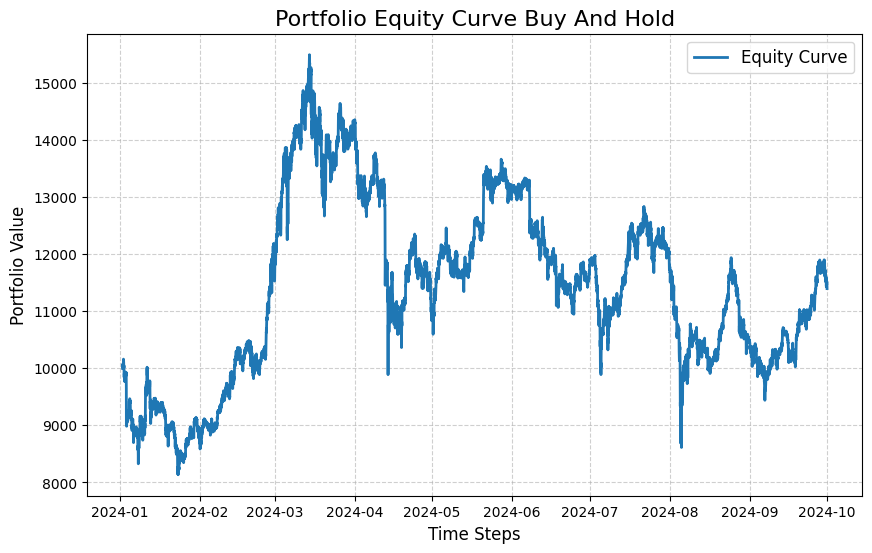

In [4]:
# buy and hold
buy_and_hold_weights = np.ones(12) / 12 # Equal allocation
buy_and_hold_equity = [10000]
pf_previous = 10000

for i in range(len(ds) + 48):
    Xt, _ = ds[i]
    yt = 1 / Xt[0, :, -2] # Price relatives
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    reward = np.dot(buy_and_hold_weights, yt.cpu().numpy())  # No rebalancing
    pf_current = pf_previous * reward
    buy_and_hold_equity.append(pf_current)
    pf_previous = pf_current

cl_price = portfolio.get_close_price()
dates = cl_price.index
plt.figure(figsize=(10, 6))
plt.plot(dates[50:], buy_and_hold_equity, label="Equity Curve", linewidth=2)
plt.title("Portfolio Equity Curve Buy And Hold", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [ ]:
calculate_total_return(buy_and_hold_equity)

Training Started for DDPG Agent
Episode 1 - Actor Loss: -0.0225, Critic Loss: 0.6205, Total Reward: 459.5750
Episode 2 - Actor Loss: -0.0352, Critic Loss: 0.5778, Total Reward: 371.2970
Episode 3 - Actor Loss: -0.0472, Critic Loss: 0.5803, Total Reward: 405.7028
Episode 4 - Actor Loss: -0.0597, Critic Loss: 0.5841, Total Reward: 328.3551
Episode 5 - Actor Loss: -0.0712, Critic Loss: 0.5687, Total Reward: 395.9289
Episode 6 - Actor Loss: -0.0843, Critic Loss: 0.4979, Total Reward: 403.3072
Episode 7 - Actor Loss: -0.0974, Critic Loss: 0.5042, Total Reward: 379.2019
Episode 8 - Actor Loss: -0.1105, Critic Loss: 0.4722, Total Reward: 387.8471
Episode 9 - Actor Loss: -0.1232, Critic Loss: 0.6447, Total Reward: 335.8835
Episode 10 - Actor Loss: -0.1345, Critic Loss: 0.4581, Total Reward: 345.6393
Episode 11 - Actor Loss: -0.1455, Critic Loss: 0.4780, Total Reward: 334.3213
Episode 12 - Actor Loss: -0.1564, Critic Loss: 0.5034, Total Reward: 330.2950
Episode 13 - Actor Loss: -0.1672, Critic 

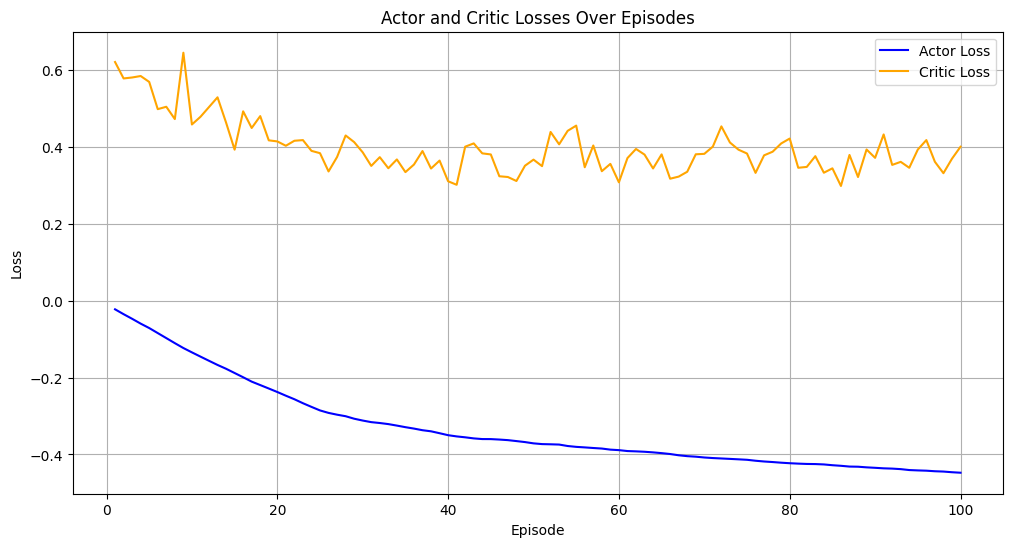

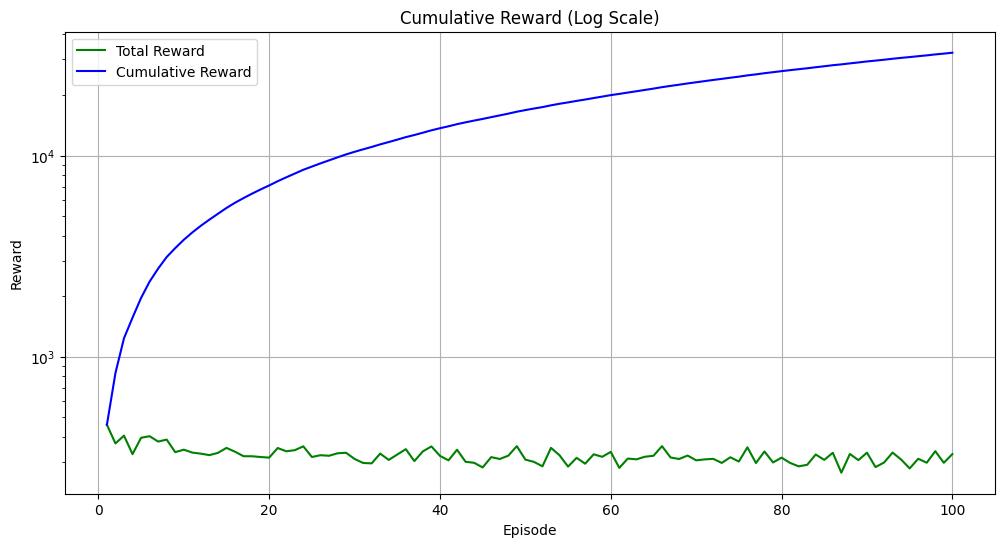

In [5]:
# train agent
agent.train(100);

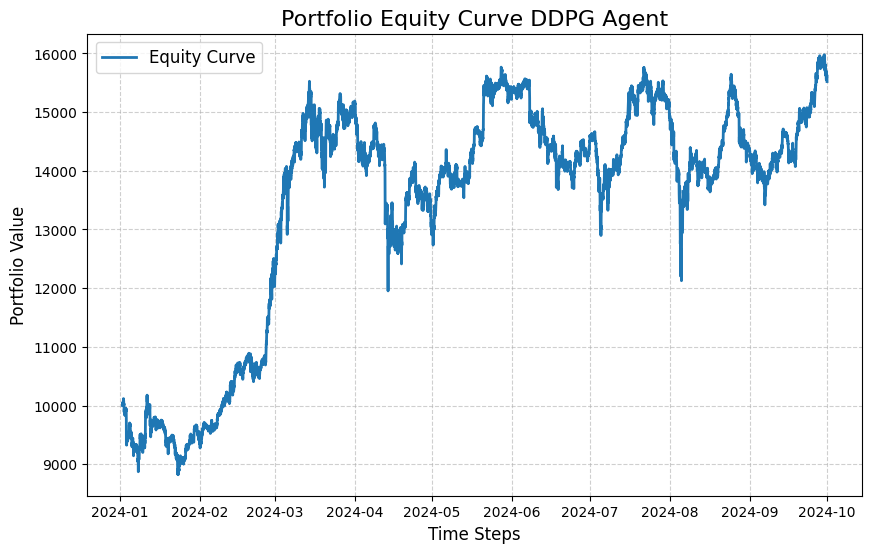

In [6]:
# checking pvm as it should be similar to buy and hold prior to training
import numpy as np
import matplotlib.pyplot as plt
weights = []
ds = KrakenDataSet(portfolio, 50, 1)
cl_price = portfolio.get_close_price()
dates = cl_price.index


pf_previous = 10000
agent_equity_curve = [pf_previous]
total_reward = 0
weights = []

for i in range(len(ds) + 48):
    Xt, prev_index = ds[i]
    yt = 1 / Xt[0, :, -2]
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    wt = agent.pvm.get_memory_stack(prev_index + 1)
    wt_cash = 1 - wt.sum()
    wt = torch.concat([wt_cash.unsqueeze(0), wt], dim=-1)
    weights.append(wt)
    reward = torch.dot(wt, yt) 
    pf_current = pf_previous * reward
    agent_equity_curve.append(pf_current.item())
    pf_previous = pf_current

# Plot the equity curve
plt.figure(figsize=(10, 6))
plt.plot(dates[50:], agent_equity_curve, label="Equity Curve", linewidth=2)
plt.title("Portfolio Equity Curve DDPG Agent", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [9]:
calculate_total_return(agent_equity_curve)

55.2096484375

In [10]:
rewards = [exp.reward for exp in agent.replay_memory.buffer]

Reward Min: -6.687890169595142, Reward Max: 8.253338550786848
Reward Mean: 0.3733951751029744, Reward Std: 0.650692343716845


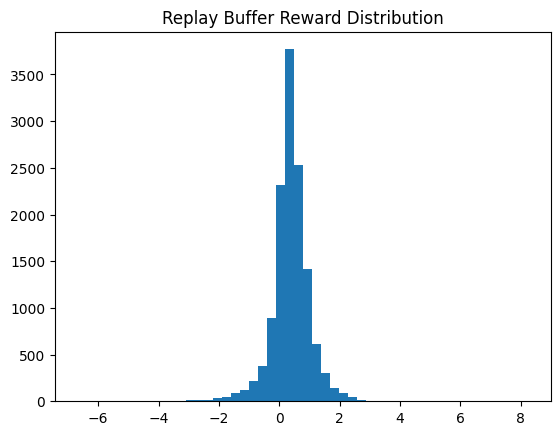

In [11]:
print(f"Reward Min: {min(rewards)}, Reward Max: {max(rewards)}")
print(f"Reward Mean: {np.mean(rewards)}, Reward Std: {np.std(rewards)}")
plt.hist(rewards, bins=50)
plt.title("Replay Buffer Reward Distribution")
plt.show()

[-0.04478134214878082,
 1.0,
 0.5285455406330314,
 0.09879024946546708,
 0.12461410641710582,
 1.1151893942480051,
 0.13054462277162765,
 -0.35700804909653355,
 0.14876956474251282,
 0.8427776637506268,
 0.6968331704669017,
 1.066375785847491,
 0.04241584453692591,
 -0.030828337055517813,
 0.5563666835385558,
 -0.5477781507183523,
 -1.1841163417879763,
 0.5978251335188266,
 0.365543516040667,
 1.315499759980701,
 -1.1523073137326076,
 0.04496289074949073,
 -1.2069668016542348,
 0.32865890548557913,
 -0.9749042384235758,
 0.8091114094239492,
 0.8618092300524578,
 -0.12633396388701376,
 -0.694608945690297,
 0.823657680446122,
 0.7043415685386908,
 0.620937030317797,
 0.758342042038117,
 -0.10293397888382039,
 0.875890434879325,
 0.8573460809725995,
 -0.7866752800647538,
 -0.2604689208070756,
 0.5529154329159386,
 1.823612282899239,
 -0.21036810780676013,
 -1.4039515573326464,
 -0.027711648377361627,
 1.4217255682909047,
 0.5616016013122506,
 -0.8780882343919283,
 -1.0498542555841903,
 0.